<a href="https://colab.research.google.com/github/ArtemKarDev/sber_virt_practic/blob/main/sber_ump_money_level_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

...в процессе разработки...

Дано: 
подневные данные объема расчетных счетов физических лиц

Задача:
спрогнозировать объем стабильных средств на расчетных счетах клиентов без сроков погашения. 

Для чего: 
использовать прогнозы при обеспечения необходимого уровня средств для выполнения стратегических целей банка, нарпимер кредитования.

In [1]:
# загружаем датасет в ноутбук с моего google-диска
!wget 'https://drive.google.com/uc?id=1vklQp9adBYK8V2YSyGBzcHkq8lKywil_' -O sber_virt_stud_data.csv

--2022-08-21 09:25:41--  https://drive.google.com/uc?id=1vklQp9adBYK8V2YSyGBzcHkq8lKywil_
Resolving drive.google.com (drive.google.com)... 172.253.122.139, 172.253.122.101, 172.253.122.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/su94r2149e49de64etkq4nbv4eampfhd/1661073900000/00838955718561688027/*/1vklQp9adBYK8V2YSyGBzcHkq8lKywil_?uuid=d57b9131-b1d6-4437-abfe-4d17b5f66a23 [following]
--2022-08-21 09:25:41--  https://doc-14-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/su94r2149e49de64etkq4nbv4eampfhd/1661073900000/00838955718561688027/*/1vklQp9adBYK8V2YSyGBzcHkq8lKywil_?uuid=d57b9131-b1d6-4437-abfe-4d17b5f66a23
Resolving doc-14-14-docs.googleusercontent.com (doc-14-14-docs.googleusercontent.com)... 172.253.63.132, 2607:f8b0:4004:c08::84
Connecting to do

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa import api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

!pip install pmdarima
from pmdarima.arima import auto_arima

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def my_adfuller(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    resid = real - forecast
    dftest = adfuller(resid) #, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    # #real=np.array(real[real.columns[0]].values)
    # forecast=np.array(forecast)
    # print('MAD:', round(abs(real-forecast).mean(),4))
    # print('MSE:', round(((real-forecast)**2).mean(),4))
    # print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    # print('MPE:', round(((real-forecast)/real).mean(),4))
    # print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    

def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    

In [4]:
data = pd.read_csv('sber_virt_stud_data.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   REPORTDATE;VALUE  2111 non-null   object
dtypes: object(1)
memory usage: 16.6+ KB


In [6]:
data.head(10)

,REPORTDATE;VALUE
0,30.12.2013;3457625638
1,31.12.2013;3417092149
2,01.01.2014;3417092149
3,02.01.2014;3417092149
4,03.01.2014;3417092149
5,04.01.2014;3417092149
6,05.01.2014;3417092149
7,06.01.2014;3320846785
8,07.01.2014;3320846785
9,08.01.2014;3630283744


У нас имеется 2111 записей в одной колонке в строковом виде, без пропусков. Похоже что данные ежедневные. Данные необходимо преобразовать для того чтобы сними можно было работать далее, азделить на колонку с датами и значением суммарного объёма средств клиентов.

In [7]:
data['date']  = data.iloc[:,0].apply(lambda x: datetime.datetime.strptime(x.split(';')[0],"%d.%m.%Y"))
data['value'] = data.iloc[:,0].apply(lambda x: int(x.split(';')[1]))

Сделаю колонку с датами индесками, будет проще исследовать временной ряд.

In [8]:
# сделаем колокнку с датами инексом
data = data.set_index('date', drop=False).sort_index()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   REPORTDATE;VALUE  2111 non-null   object        
 1   date              2111 non-null   datetime64[ns]
 2   value             2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 66.0+ KB


In [10]:
data.describe(datetime_is_numeric=True)

,date,value
count,2111,2.111000e+03
mean,2016-11-19 00:00:00,3.389668e+10
min,2013-12-30 00:00:00,3.282810e+09
25%,2015-06-10 12:00:00,1.824160e+10
50%,2016-11-19 00:00:00,3.021352e+10
75%,2018-04-30 12:00:00,4.758339e+10
max,2019-10-10 00:00:00,7.822860e+10
std,NaN,1.875474e+10


In [11]:
# функция для отображения графиков
def show_graph(data, x, y, title, xlabel, ylabel, size=(15,5)):
    fig = plt.figure(figsize=size)
    sns.lineplot(data=data, x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True);

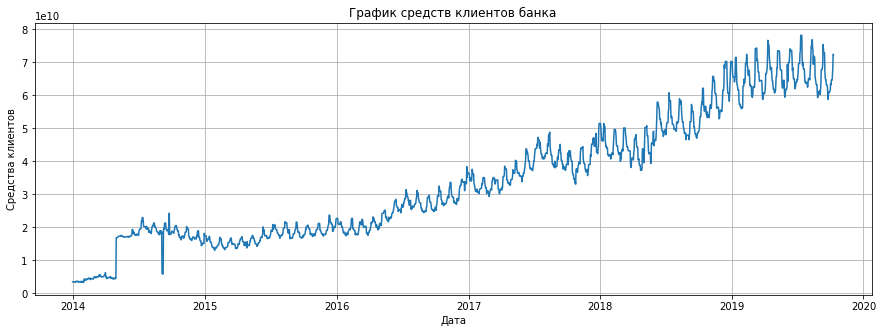

In [12]:
show_graph(data,'date', 'value',title='График средств клиентов банка', xlabel='Дата',  ylabel='Средства клиентов')

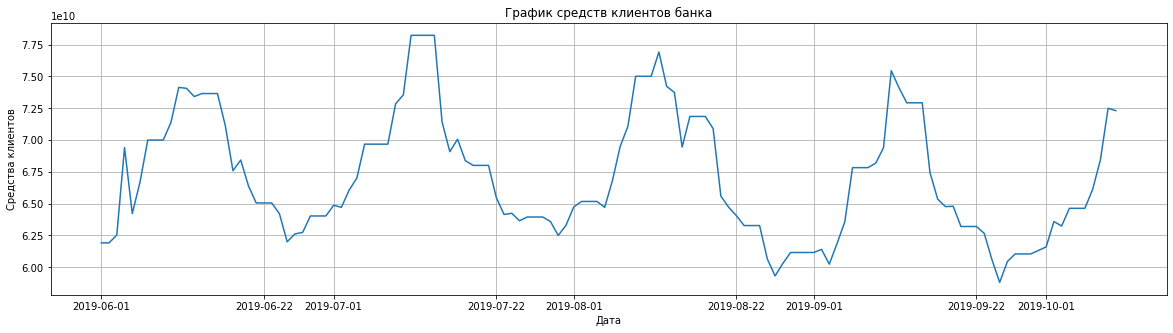

In [13]:
# посмотрим график последнего месяца
show_graph(data['2019-06':],'date', 'value' ,'График средств клиентов банка', 'Дата','Средства клиентов',size=(20,5))

Преобразовали исходные данные: они охватывают временной период с 2014 до октября 2019 годы (включительно).
При рассмотрении послених нескольких месяцев видно периодичные подьёмы значений к середине месяца и спады к концу -  скорее всего  это связано с выплатами зарплат на эти эти периоды на счета клиентов.
В начале 2014 года видимо был тестовый запуск сбора данных - виден реский скачек в значениях, и разрыв в сентябре -  считаю что данный год лучше исключить из данных для построенияпрогнозов.

In [14]:
data = data['2014-10':]

## Исследование данных

Далее продолжим анализа с помощью: скользящих средних, сглаживаний и их вариаций.

## Скользящая средняя 

In [15]:
def plotMovingAverage(data, wind, period='day/s'):
    plt.figure(figsize=(25,8))
    for n in wind:
        rolling_mean = data.rolling(window=n).mean()
        plt.plot(rolling_mean, label=f"Скользящая средняя\n за {n} {period}")
    plt.title(f"Скользящая средняя") 
    plt.axis('tight')
    plt.legend(loc="upper left")
    plt.grid(True)

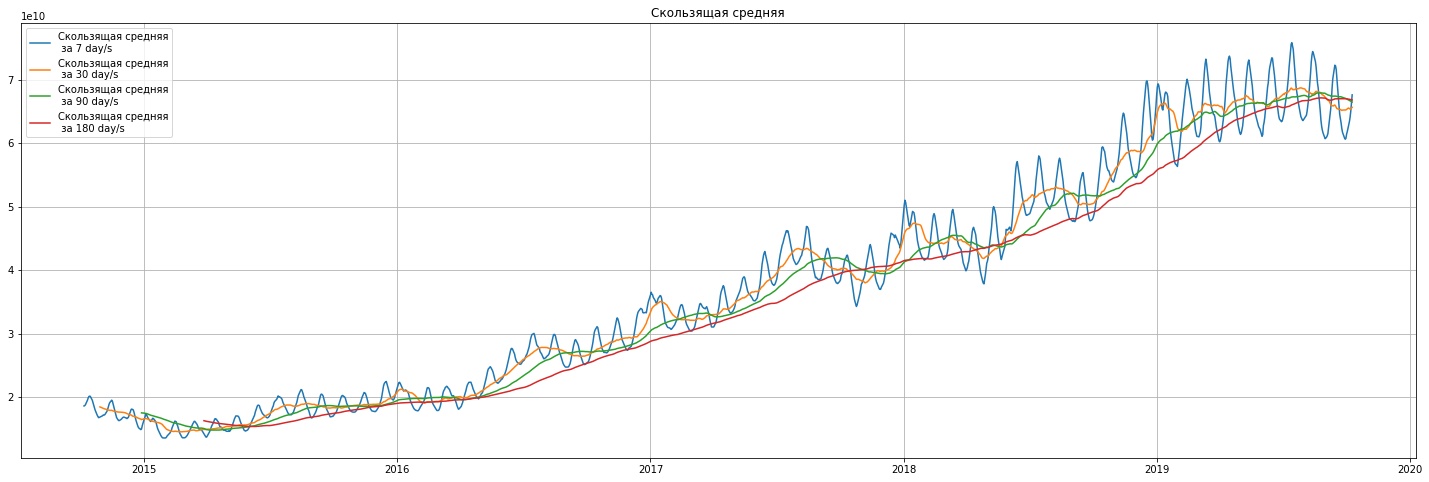

In [16]:
plotMovingAverage(data[['value']], [7,30,90,180])

Рассмотрим скользящие за неделю, месяц, квартал и полугодие.
Скользящие средние сгладили график - это позволяет поближе ознакомиться с трендами.

Колебания значений от недели к неделе сильно скачет и практические повторяет исходный график - показывая колебания в нутри месяца , но уже на месяцной скользящей видно интересный момент - возрастания значений в начале и середине года (скорее всего полугодовые премии повлияли). 

Очевидено движение тренда из года в год на увеличение занчений.

Я не использовал экспоненциальную скользящую среднюю так она больше реагирует на изменения значений и больше фокусируется на последние значения в окне.

## Стабильный уровень.
 ниже которого не опустится суммарный обьем расчетных счетов, то есть минимальные уровень средств в определенный период.
 В задаче требуется спрогнозировать стабилный уровень на будущий период от 1 месяца до 12 месяцев.
 

Я предполагаю что значения зависят от выплат заработных плат сделаю ресемплирование на месячный период c агрегирующей функцией - среднее арифметическое <br><br>
А также целью задачи является нахождение минимального возможного объёма средств за выбранный период по этому я также создам столбец и для минимальных месячных значений

In [17]:
data_res = data.resample('1M').agg({"value": [np.min, np.mean, np.max]})[['value']]
data_res.columns = ['_'.join(col) for col in data_res.columns]

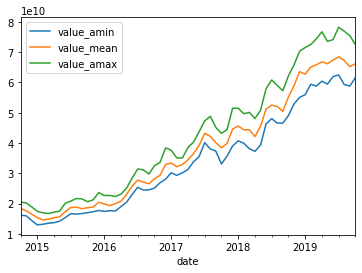

In [18]:
data_res.plot(); 

Как видно из графика - с течением времени и чем выше тренд тем больше разница между минимальным и максимальным значение в месяце. 

Посмотрим на тренды циклы и сезонность последнего года с помощью seasonal_decompose


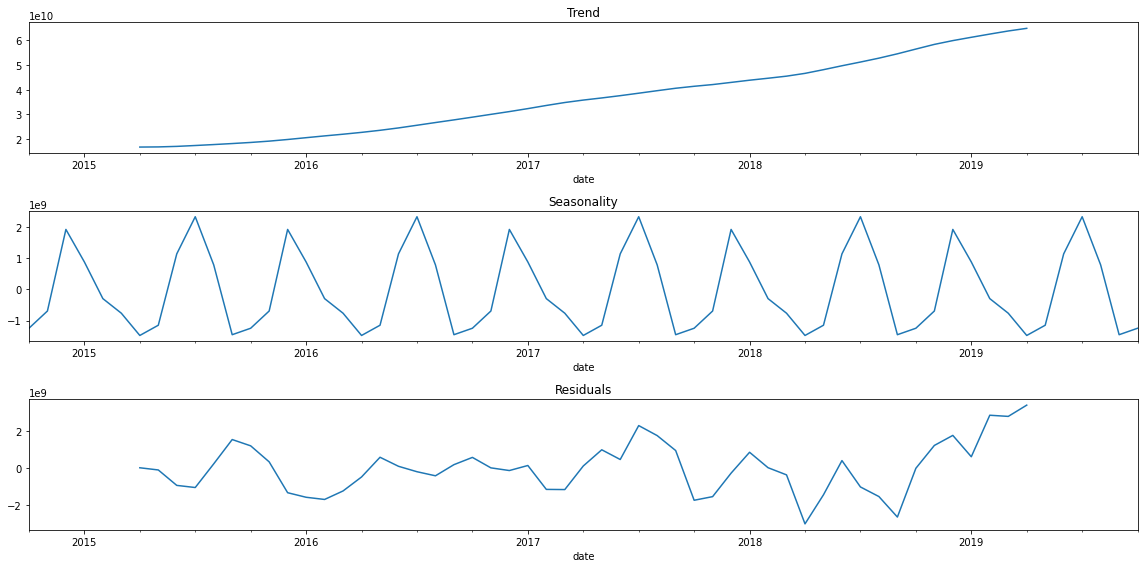

In [19]:
decomposed = seasonal_decompose(data_res[['value_mean']]) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд выглядит линейным , отчетливовиды сезоные выплаты премий на середину и конец года.

Остатки сильно вариируются , но они на протяжении рассматримоего периода стабильно держатся в промежутке от -2 до 2, но в последний год значения остатков не похожи на предыдущие.

## Модель Хольта-Винтерса

Модель Хольта-Винтерса использует идеи модели экспоненциального сглаживания, но является более сложной и может применяться к рядам, содержащим тенденцию и сезонность

In [20]:
train = data_res[:'2018'][['value_amin']]
test = data_res['2019':][['value_amin']]
holt1 = smt.ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


seasonal_periods – мы подсказываем модели количество сезонных периодов

trend и seasonal я поставил  аддитивными (мультипликатиыние комбинации показали результаты хуже)

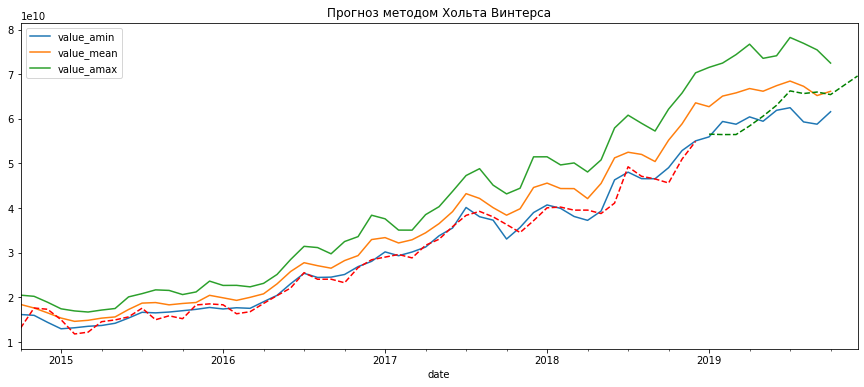

In [21]:
ax = data_res.plot(figsize=(15,6),  title="Прогноз методом Хольта Винтерса" )
holt1.fittedvalues.plot(ax=ax, style='--', color='red')
holt1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

Как видим данная модель примерно описывает данные на которых училась, но есть ошибки видимо из-за слома тренда в конце 2017года.   а на валидационных совсем не хорошо.

Проверим стационарность остатков и основные метрики для трейновых данных

In [22]:
#  функция в которой тест Фуллера применяется к разности реальных данных и предсказаний
my_adfuller(train, holt1.fittedvalues)

Тест на стационарность:
	T-статистика = -7.165
	P-значение = 0.000
Критические значения :
	1%: -3.5745892596209488 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.9239543084490744 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6000391840277777 - Данные  стационарны с вероятностью 90% процентов


In [23]:
metrics_short(train, holt1.fittedvalues)

MAD: 1190379131.1275
MSE: 2.415893427213882e+18
MAPE: 0.0503
MPE: 0.0053
Стандартная ошибка: 1554314455.7051


Тест на стационарность прошли, модель смогла извлечь всю информацию от трендах и сезонности из обучающего ряда.
- MAD в среднем модель ошибается на 1.2 млрд 
- MSE надо смотреть в сравнении с другими моделями
- MAPE получается что ошибаемся всего на примерно 5 процентов
- MPE говорит что модель не до предсказывает всего примерно на пол процента
- стандартная ошибка сообщает что фактическая величина (с вероятностью 68%) будет лежать в интервале примерно +-1.5 млрд от предсказанной величины.

Проверим стационарность остатков и основные метрики для валидационных данных

In [24]:
my_adfuller(test, holt1.forecast(len(test)))
metrics_short(test, holt1.forecast(len(test)))

Тест на стационарность:
	T-статистика = -0.842
	P-значение = 0.806
Критические значения :
	1%: -4.473135048010974 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.28988060356653 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.7723823456790124 - Данные не стационарны с вероятностью 90% процентов
MAD: 3129834065.9571
MSE: 1.421226866962218e+19
MAPE: 0.0522
MPE: -0.0278
Стандартная ошибка: 3769916268.2508


Данные уже не стационарны, и остальные результаты значительно ухудшились , что говорит либо об изменении условий и закономерностей, либо о том что модель не подходит.
опробуем модель на полных данных и помотри что нам покажет в будущем

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


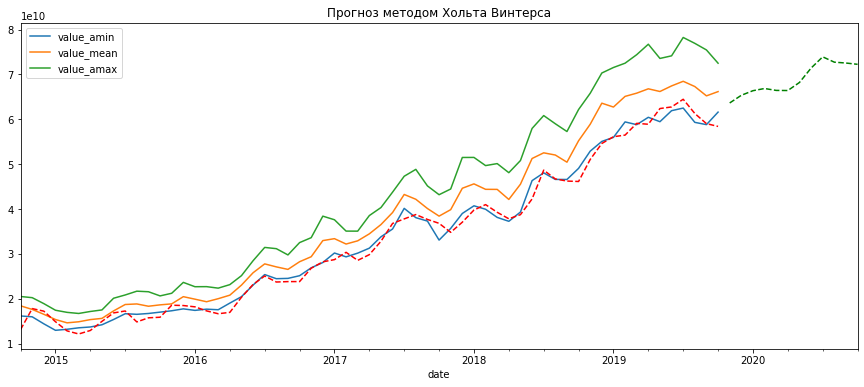

In [25]:
holt1 = smt.ExponentialSmoothing(data_res[['value_amin']], seasonal_periods=12, trend='add', seasonal='add').fit()
ax = data_res.plot(figsize=(15,6),  title="Прогноз методом Хольта Винтерса" )
holt1.fittedvalues.plot(ax=ax, style='--', color='red')
holt1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

предсказания на будущи период кажутся правдоподобными - наблюдаюся тренд и сезонность.
Сравним данный результ с другой более сложной моделью. 

## постромение модели SARIMA
Сезонное авторегрессионное интегрированное скользящее среднее -
поддерживает одномерные данные временных рядов с сезонным компонентом.
Настройка SARIMA требует выбора гиперпараметров как для трендовых, так и для сезонных элементов ряда.

Элемента тренда: 
- p: Порядок авторегрессии тренда.
- d: Порядок изменения тренда.
- q: Тренд скользящей средней.

Элементы сезнности:
- P: Сезонный порядок авторегрессии.
- D: Порядок сезонных разниц.
- Q: Сезонный порядок скользящих средних.(последний значимый сезонный лаг на графике автокореляции (после вычитания ) умноженный на m)
- м: Количество временных шагов за один сезонный период.

SARIMA(p,d,q)(P,D,Q)m

Элементы тренда могут быть выбраны путем тщательного анализа графиков ACF и PACF с учетом корреляции последних временных шагов. 
Точно так же графики ACF и PACF могут быть проанализированы, чтобы определить значения для сезонной модели, взглянув на корреляцию по временным шагам сезонной задержки.

Стоит ли рассматривать экзогеннные переменные(SARIMAX)?
нам не протребуется определения стабильного уровня на каждый день и только на сренемесяцный уровень. Соответсвенно не будут иметь большго влияния празники и выходные дни. Но есть месяцы премиальных выплат Квартальные полугодовые и годовые. Попробую добавить экзогенные переменные в виде месяцев года и количества дней в месяце.



## Стационарность



Проверю данные временного ряда на стационарность -данный для построения модели прогнозирования должны быть гомоскедастичными, с постоянным мат ожиданием и независимой от времени ковариационной функцией. Так будет проще строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих.

Для начала разобъю временной ряд на две последовательности. Затем рассчитаем среднее значение и дисперсию каждой группы чисел и сравним значения.

In [26]:
X = data_res['value_mean'].values
split = int(len(X) / 2)
X1, X2 = X[:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print(f'mean1={round(mean1,0)}, mean2={round(mean2,0)}')
print(f'variance1={round(var1,0)}, variance2={round(var2,0)}')

mean1=21974908831.0, mean2=52447559624.0
variance1=3.5118595995001446e+19, variance2=1.2616572204422563e+20


разница в среднем и дисперсии очень большая - значит эти параметры меняются с течением времени - и речь может идти об отсутствии стационарности

## тест Дикки-Фуллера

проверим данные на стационарность с помощью теста Дикки-Фуллера

Нулевая гипотеза (H0): предполагает, что временной ряд нестационарный - имеет некоторую временную структуру.

Альтернативная гипотеза (H1): предполагает, что временной ряд является стационарным. Он не имеет временной структуры.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.996404


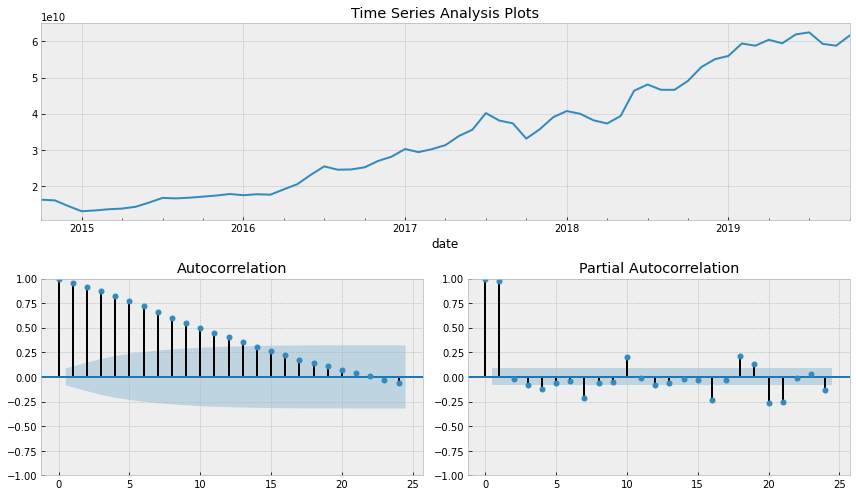

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(data_res['value_amin'], lags=24)

p-value выше порогового значения (5%)<br>
мы не можем отвергнуть нулевую гипотезу  -  временной ряд не стационарен. Критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию.

На графиках функций авторегрессий можем собрать некоторую информацию (интуиция):
- На диаграмме автокорреляции можем видеть что значения текущего ряда и рядя с запаздыванием = 12 перестают значимо отличаться
- на диаграмме частной автокорреляции видно что значение лага  после которого большинство лагов не являются значимыми = 1  (параметр p), 

In [28]:
# создадим ряд со смещением на один месяц
data_shift = data_res[['value_amin']] - data_res[['value_amin']].shift(periods=1,fill_value=0)

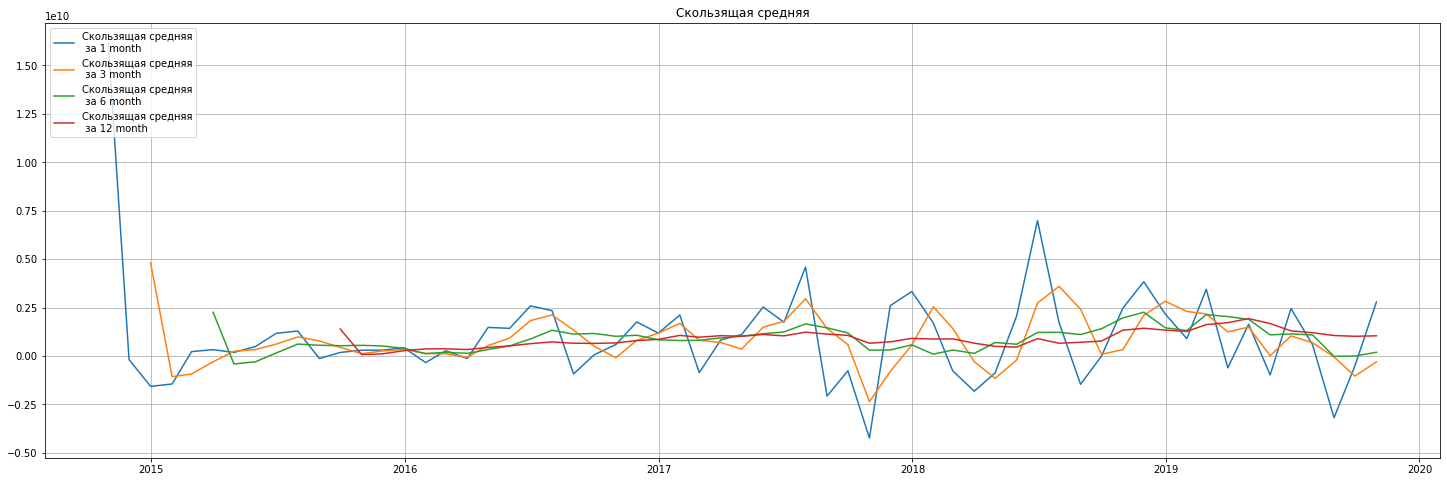

In [29]:
# помотрим на авторегресионные скользящие средние временного ряда 
plotMovingAverage(data_shift, [1,3,6,12],'month')

Изобразил модель авторегрессионного скользящего среднего (ARMA (p, q)) - где р = 1(авторегрессия с лагом 1) и при q = 12 (скользящая средняя 12 порядка) значения практически перестали значимо колебаться. Глобальный уровень (среднее) и среднее отклонение от этого уровня (дисперсия) остаются постоянными на протяжении ряда. 

Разности временного ряда более стационарны, нелинейный тренд преобразовался в линейный.



Посмотрим еще раз на тест

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Критерий Дики-Фуллера: p=0.000000


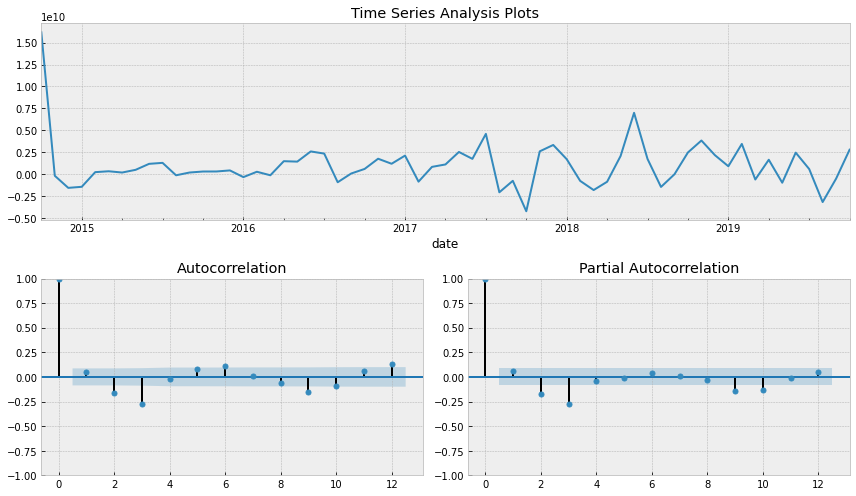

In [30]:
tsplot(data_shift['value_amin'], lags=12)

Получили стационарный ряд

##  Моделирование SARIMA
Теперь можно перейти к построению модели SARIMA. Воспользуюсь библиотекой для автоподбора параметров 



In [290]:
train = data_res[:'2018'][['value_amin']]
test = data_res['2019':][['value_amin']]

model = auto_arima(train, 
                   trend='t',
                   #start_p=1, 
                    #start_q=1,
                    #test='adf',       # use adftest to find optimal 'd'
                    #max_p=3, max_q=3, # maximum p and q
                    m=12,             # frequency of series (if m==1, seasonal is set to FALSE automatically)
                    #d=None,           # let model determine 'd'
                    seasonal=True,   # No Seasonality for standard ARIMA
                    trace=True,      #logs 
                    error_action='warn', #shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2275.705, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2277.599, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2275.705, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2276.210, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2278.203, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2277.185, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2276.866, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2278.872, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 3.083 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, trend='t', with_intercept=False)

In [306]:
mod_sarimax = sm.tsa.statespace.SARIMAX(train,
                                    order=(0, 1, 0),
                                    seasonal_order=(0, 0, 0, 12), 
                                    trend='t',
                                    #exog=other_data_train
                                    )
results = mod_sarimax.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.152e+07   6.72e+06      4.691      0.000    1.84e+07    4.47e+07
sigma2      3.157e+18   2.15e-06   1.47e+24      0.000    3.16e+18    3.16e+18


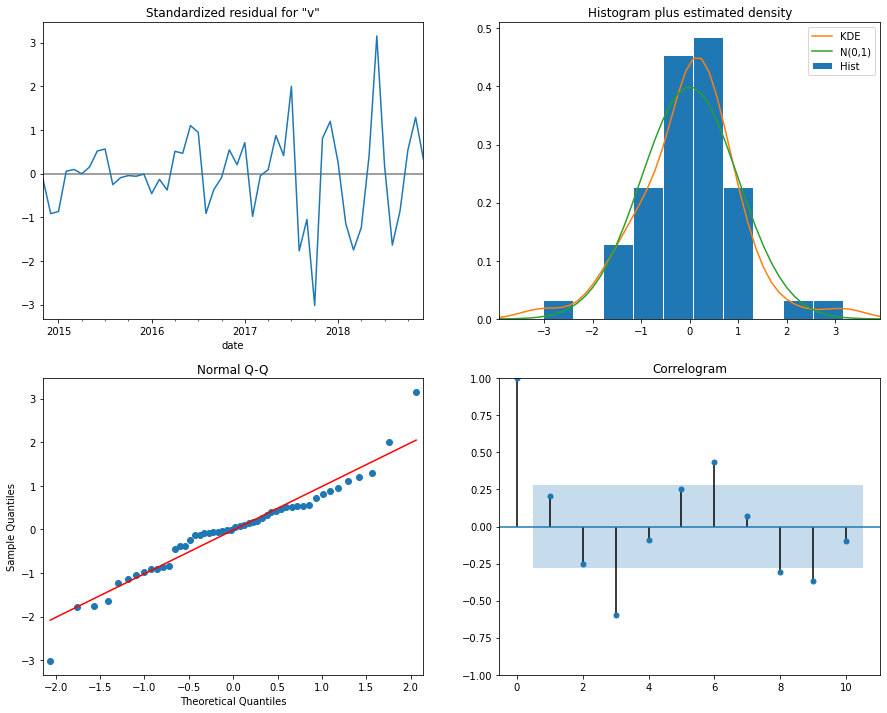

In [307]:
results.plot_diagnostics(figsize=(15,12));

Распределение ошибок должно стремиться к нормальному

In [187]:
# predict=results.get_prediction()
# predict.predicted_mean[:10]

In [308]:
predict=results.get_prediction(start='2015-02-28')
my_adfuller(train['2015-02-28':], predict.predicted_mean)
metrics_short(train['2015-02-28':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -7.986
	P-значение = 0.000
Критические значения :
	1%: -3.5885733964124715 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.929885661157025 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6031845661157025 - Данные  стационарны с вероятностью 90% процентов
MAD: 1273785986.3456
MSE: 3.250905990222223e+18
MAPE: 0.0397
MPE: 0.0019
Стандартная ошибка: 1803026896.6996


метрика на трейне показывают результат чуть лучше чем у модели Хольта.

Взглянем на предсказания на будущий период.

In [298]:
mod_sarimax = sm.tsa.statespace.SARIMAX(data_res[['value_amin']],
                                    order=(0, 1, 0),
                                    seasonal_order=(0, 0, 0, 12), 
                                    trend='t',
                                    #exog=other_data_train
                                    )
results = mod_sarimax.fit()

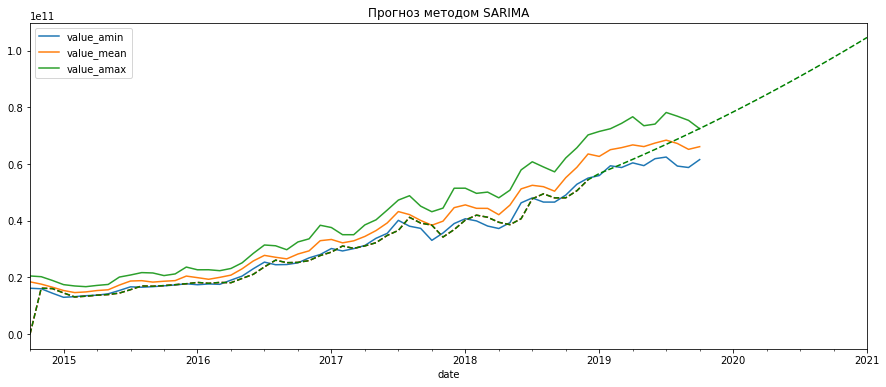

In [309]:
predict=results.get_prediction(#start='2015-02-28',
                               #start='2019',
                               end='2021')
ax = data_res.plot(figsize=(15,6),  title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

к сожалению данная конфигурация параметров модели SARIMA несмогла описать закономерности кроме тренда. 

## Feature Engineering

Создадим некоторые признаки для обучения модели: месяц года, отстающие значений и разница между макимальным и средним и минимальными значениями

In [311]:
data_res['month'] = data_res.index.month

In [355]:
data_res['month'] = data_res['month'].astype(str)

In [312]:
# для создания признаков с отстающими значениями сделаем функцию

def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1,max_lag + 1):
        data['lag_{}'.format(lag)] = data['value_mean'].shift(lag) 
        data['lag_{}'.format(lag)] = data['value_amin'].shift(lag)
    # для создания признака со скользящим средним с заданым окном и со сдвигом на одно наблюдение назад(чтоб не подглядывать)
    for roll in rolling_mean_size:
        data['roll_min{}'.format(roll)] = data['value_amin'].shift().rolling(roll).mean()
        data['roll_mean{}'.format(roll)] = data['value_mean'].shift().rolling(roll).mean()
        data['roll_max{}'.format(roll)] = data['value_amax'].shift().rolling(roll).mean()
    #data['rolling_mean'] = data['value_amin'].shift().rolling(rolling_mean_size).mean()

In [313]:
make_features(data_res, 12, [1,3,6,12])

In [314]:
data_res['max-mean'] = data_res['value_amax'] - data_res['value_mean']
data_res['mean-min'] = data_res['value_mean'] - data_res['value_amin']

In [315]:
data_res.iloc[12:].head()

,value_amin,value_mean,value_amax,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,roll_mean3,roll_max3,roll_min6,roll_mean6,roll_max6,roll_min12,roll_mean12,roll_max12,max-mean,mean-min
date,,,,,,,,,,,,,,,,,,,,,
2015-10-31,17028888205,1.864975e+10,20646452162,10,1.672901e+10,1.654459e+10,1.667574e+10,1.538821e+10,1.421316e+10,1.372028e+10,...,1.864188e+10,2.137451e+10,1.554517e+10,1.737133e+10,1.982382e+10,1.496532e+10,1.681267e+10,1.914970e+10,1.996702e+09,1.620862e+09
2015-11-30,17333052064,1.886963e+10,21232029405,11,1.702889e+10,1.672901e+10,1.654459e+10,1.667574e+10,1.538821e+10,1.421316e+10,...,1.861527e+10,2.130548e+10,1.609660e+10,1.791874e+10,2.040228e+10,1.503643e+10,1.683065e+10,1.916077e+10,2.362403e+09,1.536575e+09
2015-12-31,17757402446,2.047531e+10,23657210965,12,1.733305e+10,1.702889e+10,1.672901e+10,1.654459e+10,1.667574e+10,1.538821e+10,...,1.862072e+10,2.115064e+10,1.661658e+10,1.845781e+10,2.102105e+10,1.514840e+10,1.693359e+10,1.924248e+10,3.181900e+09,2.717908e+09
2016-01-31,17418276912,1.991641e+10,22692272499,1,1.775740e+10,1.733305e+10,1.702889e+10,1.672901e+10,1.654459e+10,1.667574e+10,...,1.933156e+10,2.184523e+10,1.701145e+10,1.898672e+10,2.160987e+10,1.542619e+10,1.726106e+10,1.963685e+10,2.775867e+09,2.498129e+09
2016-02-29,17690708156,1.934368e+10,22708779009,2,1.741828e+10,1.775740e+10,1.733305e+10,1.702889e+10,1.672901e+10,1.654459e+10,...,1.975378e+10,2.252717e+10,1.713520e+10,1.918453e+10,2.191633e+10,1.579608e+10,1.763870e+10,2.007351e+10,3.365103e+09,1.652968e+09


## Раздаление на выборки

In [375]:
data_res = data_res.dropna()
features = data_res.drop(['value_amin', 'value_amax', 'value_mean'], axis=1)
target = data_res['value_amin']
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.15)
print(features_train.shape,  target_train.shape, features_test.shape, target_test.shape )

(41, 27) (41,) (8, 27) (8,)


In [376]:

# функция для вывода графиков с предсказаниями

def show_y_pred(y, pred):
    plt.figure(figsize=(15,3))
    plt.plot(y,label='реальные данные')
    plt.plot(pred,label='предсказания')
    plt.legend(loc="upper left")
    plt.ylabel('стабильный объем стредств')
    plt.grid(True)

## LinReg

755591721.7138153


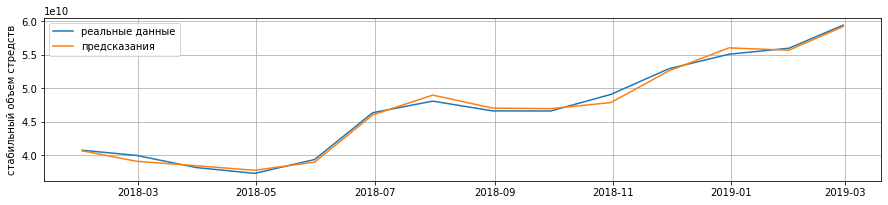

In [377]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

predicted = model_lr.predict(features_train)
df_pred = pd.DataFrame({'value_amin': target_train, 'pred': predicted})
show_y_pred(df_pred['value_amin']['2018':], df_pred['pred']['2018':])

print(mean_squared_error(target_train , predicted, squared=False))

In [378]:
my_adfuller(target_train, predicted)
metrics_short( pd.DataFrame({'value_amin':target_train}), predicted)

Тест на стационарность:
	T-статистика = -6.801
	P-значение = 0.000
Критические значения :
	1%: -3.610399601308181 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.939108945868946 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.6080629651545038 - Данные  стационарны с вероятностью 90% процентов
MAD: 602340161.6592
MSE: 5.709188499224477e+17
MAPE: 0.0202
MPE: -0.0008
Стандартная ошибка: 755591721.7138


4229299865.126446


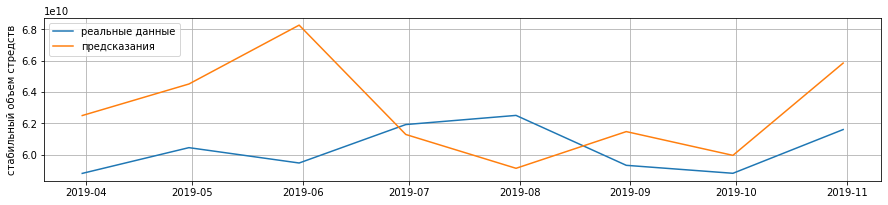

In [379]:
predicted = model_lr.predict(features_test)
df_pred = pd.DataFrame({'num_orders': target_test, 'pred': predicted})
show_y_pred(df_pred['num_orders'],df_pred['pred'])
print(mean_squared_error(target_test , predicted, squared=False))

In [380]:
my_adfuller(target_test, predicted)
metrics_short( pd.DataFrame({'value_amin':target_test}), predicted)

Тест на стационарность:
	T-статистика = -1.638
	P-значение = 0.463
Критические значения :
	1%: -5.354256481481482 - Данные не стационарны с вероятностью 99% процентов
	5%: -3.6462381481481483 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.901197777777778 - Данные не стационарны с вероятностью 90% процентов
MAD: 3510271752.8504
MSE: 1.7886977349158574e+19
MAPE: 0.0583
MPE: -0.0423
Стандартная ошибка: 4229299865.1264


In [325]:
 #pd.DataFrame({'value_amin':target_train})

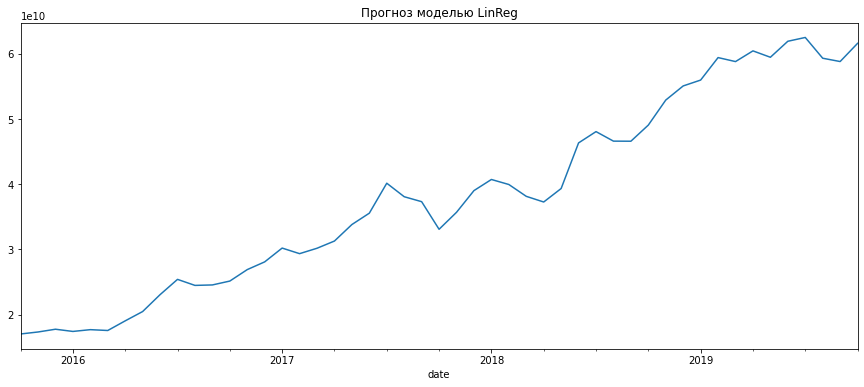

In [381]:
ax = data_res['value_amin'].plot(figsize=(15,6),  title="Прогноз моделью LinReg" )
# results.fittedvalues.plot(ax=ax, style='--', color='red')
# predict.predicted_mean.plot(ax=ax, style='--', color='green')

plt.show()

## Catboost

In [345]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [357]:
from catboost import CatBoostRegressor
cat_features = [0]
cat = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)

cat.fit(features_train, target_train,verbose=False,) #plot=True)

372305682.35568434


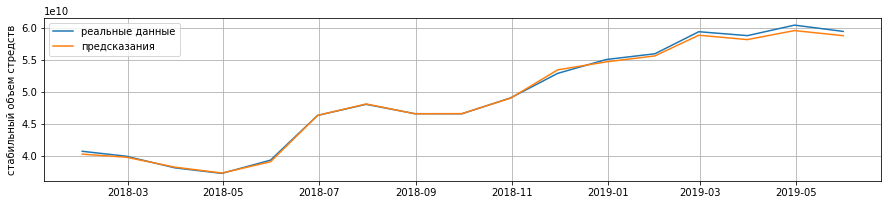

In [ ]:
predicted = cat.predict(features_train)
df_pred = pd.DataFrame({'value_amin': target_train, 'pred': predicted})
show_y_pred(df_pred['value_amin']['2018':],df_pred['pred']['2018':])

print(mean_squared_error(target_train , predicted, squared=False))

7970143886.307618


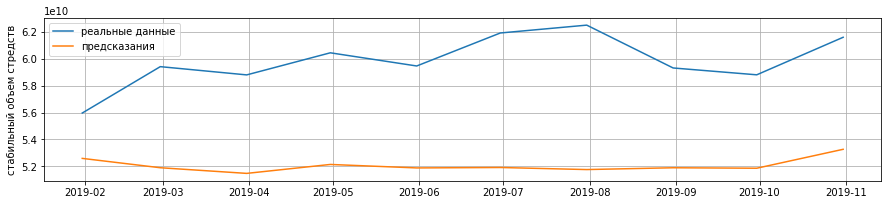

In [373]:
predicted = cat.predict(features_test)
df_pred = pd.DataFrame({'value_amin': target_test, 'pred': predicted})
show_y_pred(df_pred['value_amin'],df_pred['pred'])
print(mean_squared_error(target_test , predicted, squared=False))

In [370]:
feat_imp = cat.get_feature_importance(prettified=True)
plt.figure(figsize=(15,5))

feat_imp.plot(x='Feature Id', y='Importances', kind="bar", rot=50, ax=ax, style='--', color='green')

<Figure size 1080x360 with 0 Axes>

In [ ]:
my_adfuller(target_test, predicted)
metrics_short( pd.DataFrame({'value_amin':target_test}), predicted)

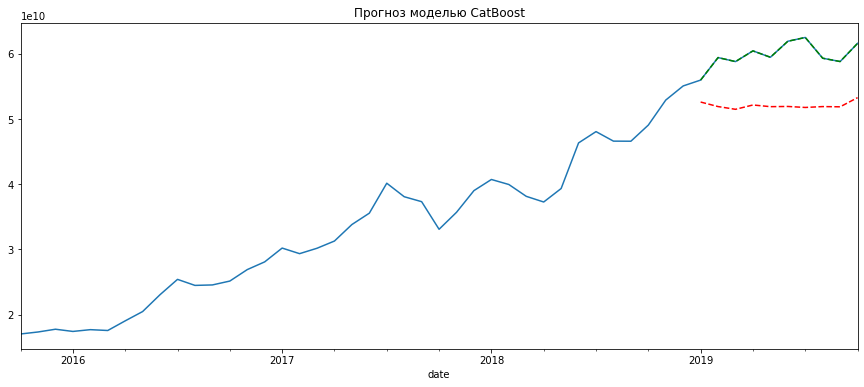

In [374]:
ax = data_res['value_amin'].plot(figsize=(15,6),  title="Прогноз моделью CatBoost" )
# results.fittedvalues.plot(ax=ax, style='--', color='red')
# predict.predicted_mean.plot(ax=ax, style='--', color='green')
df_pred['pred'].plot(ax=ax, style='--', color='red')
df_pred['value_amin'].plot(ax=ax, style='--', color='green')
plt.show()